In [1]:
import re
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import nltk
import textblob
import plotly.express as px
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from sklearn.cluster import MiniBatchKMeans
import seaborn as sns
nltk.download('vader_lexicon')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from nltk.sentiment.vader import SentimentIntensityAnalyzer as vad
import plotly
plotly.offline.init_notebook_mode (connected = True)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\sthan\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
df=pd.read_csv('Donald-Tweets!.csv')

In [3]:
df = df.rename(columns={ 'twt_favourites_IS_THIS_LIKE_QUESTION_MARK': 'Favourites'})

In [4]:
tweets = df.loc[:, ['Date', 'Time','Tweet_Text','Type','Media_Type','Hashtags','Tweet_Id','Favourites','Retweets']]

In [5]:
tweets['Hashtags']=tweets['Hashtags'].replace(np.nan,'',regex=True)
tweets['Media_Type']=tweets['Media_Type'].replace(np.nan,'',regex=True)

In [6]:
data= tweets.dropna()

In [7]:
print(data.shape)

(7375, 9)


In [8]:
# Preprocessing the data
#set all tweets in lower case 
data['Tweet_Text']=data['Tweet_Text'].str.lower()

#remove the Hashtags from the text
data['Tweet_Text']=data['Tweet_Text'].apply(lambda x:re.sub(r'\B#\S+','',x))

#remove the links from the text
data['Tweet_Text']=data['Tweet_Text'].apply(lambda x:re.sub(r"http\S+", "", x))

#remove the Special characters from the text 
data['Tweet_Text']=data['Tweet_Text'].apply(lambda x:' '.join(re.findall(r'\w+', x)))

#substitute the multiple spaces with single spaces
data['Tweet_Text']=data['Tweet_Text'].apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))

# Remove @mentions
data['Tweet_Text']=data['Tweet_Text'].apply(lambda x:re.sub('@[^\s]+','',x))


In [9]:
data.head()

Date      Time                                         Tweet_Text  \
0  16-11-11  15:26:37  today we express our deepest gratitude to all ...   
1  16-11-11  13:33:35  busy day planned in new york will soon be maki...   
2  16-11-11  11:14:20  love the fact that the small groups of protest...   
3  16-11-11   2:19:44  just had a very open and successful presidenti...   
4  16-11-11   2:10:46  a fantastic day in d c met with president obam...   

   Type Media_Type   Hashtags      Tweet_Id  Favourites  Retweets  
0  text      photo  ThankAVet  7.970000e+17      127213     41112  
1  text                        7.970000e+17      141527     28654  
2  text                        7.970000e+17      183729     50039  
3  text                        7.970000e+17      214001     67010  
4  text                        7.970000e+17      178499     36688

In [10]:
data=data[['Tweet_Text']]

In [11]:
data.head()

Tweet_Text
0  today we express our deepest gratitude to all ...
1  busy day planned in new york will soon be maki...
2  love the fact that the small groups of protest...
3  just had a very open and successful presidenti...
4  a fantastic day in d c met with president obam...

# VADER 
 

In [12]:
vader=data.copy()

sentiment=vad()
# Making additional columns for sentiment scores and the overall sentiment in the vader dataframe
sen=['Positive','Negative','Neutral']
sentiments=[sentiment.polarity_scores(i) for i in vader['Tweet_Text'].values]
vader['Negative Score']=[i['neg'] for i in sentiments]
vader['Positive Score']=[i['pos'] for i in sentiments]
vader['Neutral Score']=[i['neu'] for i in sentiments]
vader['Compound Score']=[i['compound'] for i in sentiments]#sum of all ratings which have been normalized between -1 and +1
score=vader['Compound Score'].values
t=[]
for i in score:
    if i >=0.05 :
        t.append('Positive')
    elif i<=-0.05 :
        t.append('Negative')
    else:
        t.append('Neutral')
vader['Overall Sentiment']=t

In [13]:
vader.head()

Tweet_Text  Negative Score  \
0  today we express our deepest gratitude to all ...           0.000   
1  busy day planned in new york will soon be maki...           0.000   
2  love the fact that the small groups of protest...           0.052   
3  just had a very open and successful presidenti...           0.298   
4  a fantastic day in d c met with president obam...           0.000   

   Positive Score  Neutral Score  Compound Score Overall Sentiment  
0           0.180          0.820          0.5106          Positive  
1           0.087          0.913          0.2716          Positive  
2           0.397          0.551          0.9260          Positive  
3           0.150          0.552         -0.4641          Negative  
4           0.482          0.518          0.9320          Positive

In [14]:
fig=px.histogram(data_frame=vader,x='Compound Score',color='Overall Sentiment',template='plotly')
fig.show()

C:\Users\sthan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='Overall Sentiment', ylabel='count'>

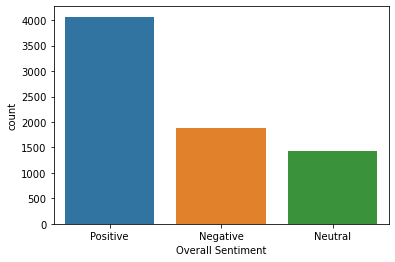

In [15]:
sns.countplot(vader['Overall Sentiment'])

In [16]:
#example
print('The tweet is :',vader['Tweet_Text'][6])
print('The vader sentiment Score of the data is :')
vader.iloc[6,1:]

The tweet is : such a beautiful and important evening the forgotten man and woman will never be forgotten again we will all come together as never before
The vader sentiment Score of the data is :


Negative Score          0.133
Positive Score            0.2
Neutral Score           0.667
Compound Score         0.4404
Overall Sentiment    Positive
Name: 6, dtype: object

In [17]:
#TFIDFVectorizer
tf_data=TfidfVectorizer()

vader_data=tf_data.fit_transform(vader['Tweet_Text'].values)#tf-idf to vectorize 
pca = PCA(n_components=3).fit_transform(vader_data.todense()) # .todense() will make this into a matrix of the tf-idf 
px.scatter_3d(x=pca[:,0],y=pca[:,1],z=pca[:,2],color=vader['Overall Sentiment'].values)




In [18]:
print(vader_data.shape)# 10439 dimensions, reduced it to 3 (to plot)

(7375, 10439)


# TextBlob

In [19]:
textblob_data=data.copy()
# Creating additional columns containing polarity score , subjectivity and overall sentiment 
sentiment=[]
subjectivity=[]
sentiment_score=[]
for i in textblob_data['Tweet_Text'].values:
    Tweet = textblob.TextBlob(i)
    sentiment_score.append(Tweet.sentiment[0])
    if Tweet.sentiment[0]<0:
        sentiment.append('Negative')
    elif Tweet.sentiment[0]>0:
        sentiment.append('Positive')
    else:
        sentiment.append('Neutral')
    subjectivity.append(Tweet.sentiment[1])

In [20]:
textblob_data['Sentiment Score']=sentiment_score
textblob_data['Subjectivity']=subjectivity
textblob_data['Overall Sentiment']=sentiment

In [21]:
textblob_data.head()


Tweet_Text  Sentiment Score  \
0  today we express our deepest gratitude to all ...         0.000000   
1  busy day planned in new york will soon be maki...         0.252121   
2  love the fact that the small groups of protest...         0.370000   
3  just had a very open and successful presidenti...         0.050000   
4  a fantastic day in d c met with president obam...         0.550000   

   Subjectivity Overall Sentiment  
0      0.000000           Neutral  
1      0.584848          Positive  
2      0.563333          Positive  
3      0.675000          Positive  
4      0.676667          Positive

In [22]:
px.histogram(data_frame=textblob_data,x='Sentiment Score',color='Overall Sentiment')

In [23]:
px.histogram(data_frame=textblob_data,x='Subjectivity',color='Overall Sentiment')

C:\Users\sthan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='Overall Sentiment', ylabel='count'>

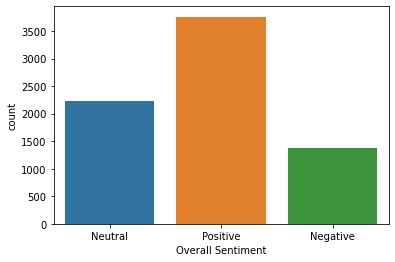

In [24]:
sns.countplot(textblob_data['Overall Sentiment'])

In [25]:
print('The tweet is :',textblob_data['Tweet_Text'][6])
textblob_data.iloc[6,1:]

The tweet is : such a beautiful and important evening the forgotten man and woman will never be forgotten again we will all come together as never before


Sentiment Score      0.416667
Subjectivity         0.833333
Overall Sentiment    Positive
Name: 6, dtype: object

In [26]:
textblob_vec=tf_data.fit_transform(textblob_data['Tweet_Text'].values)#tf-idf to vectorize


In [27]:
pca2 = PCA(n_components=3).fit_transform(textblob_vec.todense())#dimensionality reduction

In [28]:
px.scatter_3d(x=pca2[:,0],y=pca2[:,1],z=pca2[:,2],color=textblob_data['Overall Sentiment'].values)

# K-means


In [29]:
km=data.copy()

def rem_stopwords_tokenize(data,name):
      
    def getting(sen):
        example_sent = sen #['Positive', 'Negative', 'Neutral']

        stop_words = set(stopwords.words('english')) 

        word_tokens = word_tokenize(example_sent) 

        filtered_sentence = [w for w in word_tokens if not w in stop_words] 

        filtered_sentence = [] 

        for w in word_tokens: 
            if w not in stop_words: 
                filtered_sentence.append(w.lower()) 
        return filtered_sentence
    x=[]
    for i in data[name].values:
        x.append(getting(i))
    data[name]=x

# Making a function to lemmatize all the words
lemmatizer = WordNetLemmatizer() 
def lemmatize_all(data,name):
    arr=data[name]
    a=[]
    for i in arr:
        b=[]
        for j in i:
            x=lemmatizer.lemmatize(j,pos='a')
            x=lemmatizer.lemmatize(x)
            b.append(x)
        a.append(b)
    data[name]=a

In [30]:
rem_stopwords_tokenize(km,'Tweet_Text')
lemmatize_all(km,'Tweet_Text')

km['Tweet_Text']=km['Tweet_Text'].apply(lambda x:' '.join([i+' ' for i in x]))
# Removing double spaces
km['Tweet_Text']=km['Tweet_Text'].apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))


In [31]:
km.tail(5)

Tweet_Text
7370  loved firing goofball atheist penn pennjillett...
7371  hear pennjillette show broadway terrible surpr...
7372  irrelevant clown karlrove sweat shake nervousl...
7373  houstonwelder donald trump one sexy men planet...
7374           rt marklevinshow trump rove clown loser

In [32]:
# Tfidf Vectorizer, converting the tweets into vectors using TdidfVectorizer
tf=TfidfVectorizer()
# Fit transform the tweets
X=tf.fit_transform(km['Tweet_Text'].values)

tfidfvectorizer is used to convert data to term-document matrix.
If we got for exaple an entry like (0, 3408).0 represents the index of the feature extracted and 3408 is numerical notation of that particular feature.  

In [33]:
from scipy. sparse import csr_matrix
print(X)

  (0, 3408)	0.3507284106126285
  (0, 816)	0.4042596606383662
  (0, 7645)	0.3878646324641177
  (0, 3762)	0.4291502744312651
  (0, 2419)	0.39537581604415434
  (0, 3173)	0.4151326076827813
  (0, 8608)	0.2242713974956466
  (1, 3718)	0.31663473015194127
  (1, 7367)	0.2813653218038247
  (1, 6375)	0.17873229076662087
  (1, 2410)	0.3376347825573048
  (1, 4238)	0.31069535878805543
  (1, 5322)	0.2724026659884002
  (1, 7949)	0.24491224101050577
  (1, 9469)	0.2677526061430645
  (1, 5919)	0.182460267995632
  (1, 6478)	0.34479690401804364
  (1, 2354)	0.22934361335255418
  (1, 1499)	0.40920666598473904
  (2, 6729)	0.2809392887037186
  (2, 8615)	0.2726988872588515
  (2, 1933)	0.2826015699111896
  (2, 2151)	0.21928737257266018
  (2, 3770)	0.14466371057884314
  (2, 6274)	0.3715729598829814
  :	:
  (7372, 3399)	0.26643563328198666
  (7372, 1474)	0.30566782780455876
  (7372, 49)	0.22893725920112254
  (7372, 3464)	0.16023181505016784
  (7373, 7664)	0.37395651441652433
  (7373, 4109)	0.37395651441652433
  (

# X is a sparse matrix 
 Advantages of the CSR format
- efficient arithmetic operations (addition, substraction and so on

- efficient row slicing

- fast matrix vector products

Disadvantages of the CSR format
- slow column slicing operations (consider CSC)

- changes to the sparsity structure are expensive (consider LIL or DOK)

In [34]:
for i, feature in enumerate(tf.get_feature_names()[:5]):
    print(i, feature)#nuneric representation of the features 

0 00
1 000
2 007cigarjoe
3 007llisav
4 00a


the optimal k

In [35]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:                                                            #random_state-->repoduce the result
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=256, batch_size=512, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters


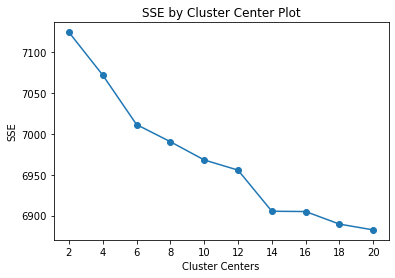

In [36]:
find_optimal_clusters(X, 20)

The optimal number of clusters according the elbow method would be 4, 6 or 14. 


In [37]:
#k=4
clusters = MiniBatchKMeans(n_clusters=4, init_size=1024, batch_size=2048, random_state=20).fit_predict(X)

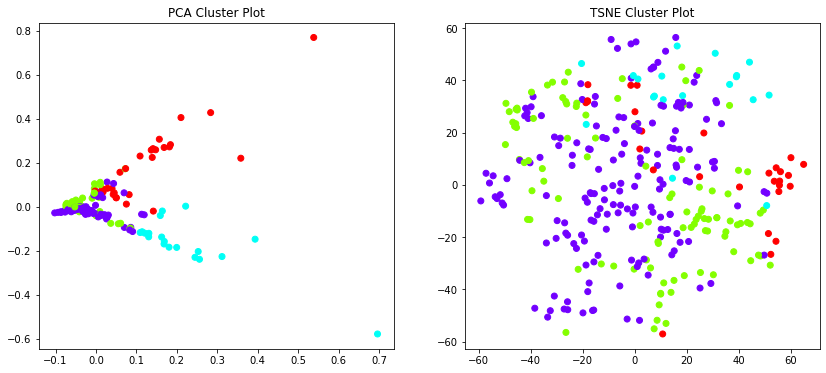

In [38]:
def plot_tsne_pca(data, labels):
    max_label = max(labels)+1
    max_items = np.random.choice(range(data.shape[0]), size=3000, replace=False)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=320, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
plot_tsne_pca(X, clusters)

The left graph presents the clustering using PCA, which is better for capturing the global structure. The right graph uses TSNE wich is better for the relationship between neighbors. 

In [39]:
clusters = MiniBatchKMeans(n_clusters=3, init_size=1024, batch_size=2048, random_state=20).fit_predict(X)
# 3 clusters for the three sentiment types (positive, negative and neutral sentiment)


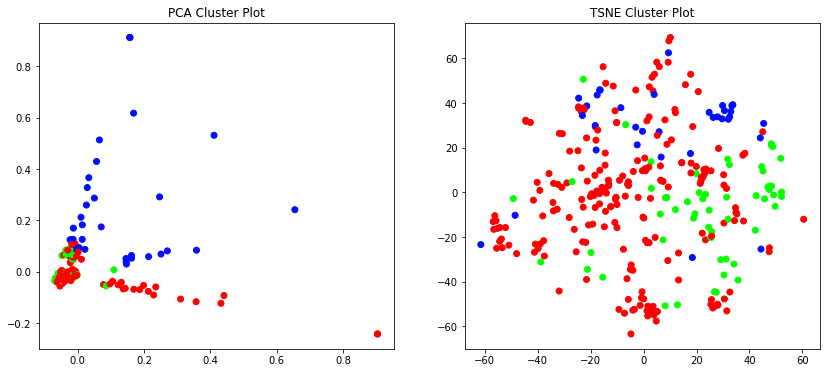

In [40]:
def plot_tsne_pca(data, labels):
    max_label = max(labels)+1
    max_items = np.random.choice(range(data.shape[0]), size=3000, replace=False)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
plot_tsne_pca(X, clusters)


The TF-IDF Score is based on words. the next code should us allow to see if we see some trends in the clusters

In [41]:
# Function  to get the words which lead to the clustering 
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(X, clusters, tf.get_feature_names(), 10)


Cluster 0
get,tonight,enjoy,new,people,clinton,amp,hillary,realdonaldtrump,thank

Cluster 1
president,vote,gop,mr,danscavino,poll,donald,rt,realdonaldtrump,trump

Cluster 2
safe,people,job,realdonaldtrump,new,poll,thank,make,america,great


In [42]:
# Making a classes column 
km['Classes']=clusters
km[km['Classes']==2].head()


Tweet_Text  Classes
2   love fact small group protester last night pas...        2
17  vote today go find polling location going make...        2
18                          today make america great         2
19  today going win great state michigan going win...        2
24  big news share new hampshire tonight poll look...        2

In [43]:
km[km['Classes']==0].head()

Tweet_Text  Classes
0   today express deep gratitude served armed force         0
1  busy day planned new york soon making importan...        0
3  open successful presidential election professi...        0
4  fantastic day c met president obama first time...        0
5  happy 241st birthday u marine corp thank service         0

In [44]:
km[km['Classes']==1].head()


Tweet_Text  Classes
8   rt ivankatrump surreal moment vote father pres...        1
9   rt erictrump join family incredible movement p...        1
10  rt donaldjtrumpjr final push eric dozen radio ...        1
14  watching election result trump tower manhattan...        1
16  need vote go poll let continue movement find p...        1

In [45]:
km['Classes'].replace({1:'Positive',0:'Negative',2:'Neutral'},inplace=True)

In [46]:
kmeans_vector=tf.fit_transform(km['Tweet_Text'].values)
pca3 = PCA(n_components=3).fit_transform(kmeans_vector.todense())
px.scatter_3d(x=pca3[:,0],y=pca3[:,1],z=pca3[:,2],color=km['Classes'].values)

Acknowledge: 
Vader and Textblob have the same clusters after the dimesnionality reduction, just the color scheme is different.

In [47]:
#VADER
print(pca)

[[-0.04131418  0.01061631 -0.04928891]
 [-0.05518397  0.02587428  0.18220709]
 [-0.04920241  0.08761954  0.00415422]
 ...
 [-0.06273702 -0.03369745  0.0055849 ]
 [-0.08161181 -0.04597409 -0.05520466]
 [-0.05692076 -0.02966534 -0.05677313]]


In [48]:
#Textblob
print(pca2)

[[-0.04131299  0.01063773 -0.04927001]
 [-0.05518305  0.02588804  0.1821881 ]
 [-0.0492024   0.08759475  0.00415063]
 ...
 [-0.06273709 -0.03370244  0.00560256]
 [-0.08161072 -0.0459273  -0.05522175]
 [-0.0569205  -0.02962856 -0.05677011]]
